In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
def visualize_detections(img, detections, combined_mask, blue_mask, red_mask):
    h, w = img.shape[:2]
    img_with_boxes = img.copy()

    # Draw bounding boxes from detections
    for detection in detections:
        parts = detection.split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:5])

        # Convert normalized coordinates back to pixels
        x_center_px = int(x_center * w)
        y_center_px = int(y_center * h)
        width_px = int(width * w)
        height_px = int(height * h)

        x1 = int(x_center_px - width_px // 2)
        y1 = int(y_center_px - height_px // 2)
        x2 = int(x_center_px + width_px // 2)
        y2 = int(y_center_px + height_px // 2)

        # Color based on class
        color = (0, 255, 0) if class_id == 0 else (0, 0, 255)
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)

        # Add label
        label = "Blue Ball" if class_id == 0 else "Red Ball"
        cv2.putText(img_with_boxes, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title("Original Image")
    axes[0,0].axis("off")

    axes[0,1].imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    axes[0,1].set_title(f"Detections ({len(detections)} found)")
    axes[0,1].axis("off")

    axes[0,2].imshow(combined_mask, cmap='gray')
    axes[0,2].set_title("Combined Mask")
    axes[0,2].axis("off")

    axes[1,0].imshow(blue_mask, cmap='Blues')
    axes[1,0].set_title("Blue Mask")
    axes[1,0].axis("off")

    axes[1,1].imshow(red_mask, cmap='Reds')
    axes[1,1].set_title("Red Mask")
    axes[1,1].axis("off")

    plt.tight_layout()
    plt.show()

In [3]:
def detect_soccer_balls(input_folder="balls", output_folder="output"):
    os.makedirs(output_folder, exist_ok=True)
    
    # Blue ranges for soccer balls
    blue_ranges = [
        ([100, 100, 100], [130, 255, 255]),
        ([100, 80, 50], [140, 255, 200]),
    ]
    
    # Red ranges for red soccer balls
    red_ranges = [
        ([0, 100, 70], [10, 255, 255]),
        ([170, 100, 70], [180, 255, 255]),
    ]

    for img_path in glob.glob(os.path.join(input_folder, "*.jpg")):

        print(f"Processing: {img_path}")
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        h, w = img.shape[:2]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # Create combined mask for blue ranges
        blue_mask = np.zeros((h, w), dtype=np.uint8)
        for lower, upper in blue_ranges:
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            blue_mask = cv2.bitwise_or(blue_mask, mask)
        
        # Create combined mask for red ranges
        red_mask = np.zeros((h, w), dtype=np.uint8)
        for lower, upper in red_ranges:
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            red_mask = cv2.bitwise_or(red_mask, mask)
        
        # Combine all masks
        combined_mask = cv2.bitwise_or(blue_mask, red_mask)
        
        detections = []
        
        for class_id, mask, color_name in [(0, blue_mask, "blue"), (1, red_mask, "red")]:
            if np.sum(mask) == 0:  # Skip if no pixels of this color
                continue
                
            # Morphological operations
            kernel_small = np.ones((3, 3), np.uint8)
            kernel_large = np.ones((7, 7), np.uint8)
            
            # Remove noise
            mask_clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_small)
            # Fill holes
            mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel_large)
            # Smooth boundaries
            mask_clean = cv2.medianBlur(mask_clean, 5)
            
            # Find contours
            contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for cnt in contours:
                area = cv2.contourArea(cnt)
                
                # Adaptive area threshold based on image size
                min_area = max(200, (h * w) // 5000) 
                max_area = (h * w) // 3  
                
                if area < min_area or area > max_area:
                    continue
                
                # Enhanced shape analysis
                perimeter = cv2.arcLength(cnt, True)
                if perimeter == 0:
                    continue
                    
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                
                # Get bounding rectangle and ellipse
                x, y, w_box, h_box = cv2.boundingRect(cnt)
                aspect_ratio = float(w_box) / h_box
                
                # Fit ellipse if we have enough points
                if len(cnt) >= 5:
                    ellipse = cv2.fitEllipse(cnt)
                    ellipse_area = np.pi * ellipse[1][0] * ellipse[1][1] / 4
                    area_ratio = area / (ellipse_area + 1e-6)
                else:
                    area_ratio = 0.5
                
                # Enhanced filtering for soccer ball detection
                is_ball = (
                    0.4 < circularity < 1.4 and          # Reasonably circular
                    0.6 < aspect_ratio < 1.4 and        # Roughly square bounding box
                    0.3 < area_ratio < 1.2 and          # Good fit to ellipse
                    w_box > 20 and h_box > 20            # Reasonable size
                )
                
                if is_ball:
                    # Normalize coordinates for YOLO format
                    x_center_norm = (x + w_box / 2) / w
                    y_center_norm = (y + h_box / 2) / h
                    width_norm = w_box / w
                    height_norm = h_box / h
                    
                    # Add confidence score based on shape metrics
                    confidence = min(1.0, (circularity + area_ratio) / 2)
                    
                    detection_line = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"
                    detections.append(detection_line)
                    
                    print(f"  Detected {color_name} ball: area={area:.0f}, circularity={circularity:.3f}, confidence={confidence:.3f}")
        
        # Save detections
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        output_path = os.path.join(output_folder, base_name + ".txt")
        
        with open(output_path, "w") as f:
            for detection in detections:
                f.write(detection + "\n")
        
        print(f"  Saved {len(detections)} detections to {output_path}")
        # Visualization
        visualize_detections(img, detections, combined_mask, blue_mask, red_mask)


Processing: balls\ball_1.jpg
  Detected red ball: area=38469, circularity=0.795, confidence=0.894
  Saved 1 detections to output\ball_1.txt


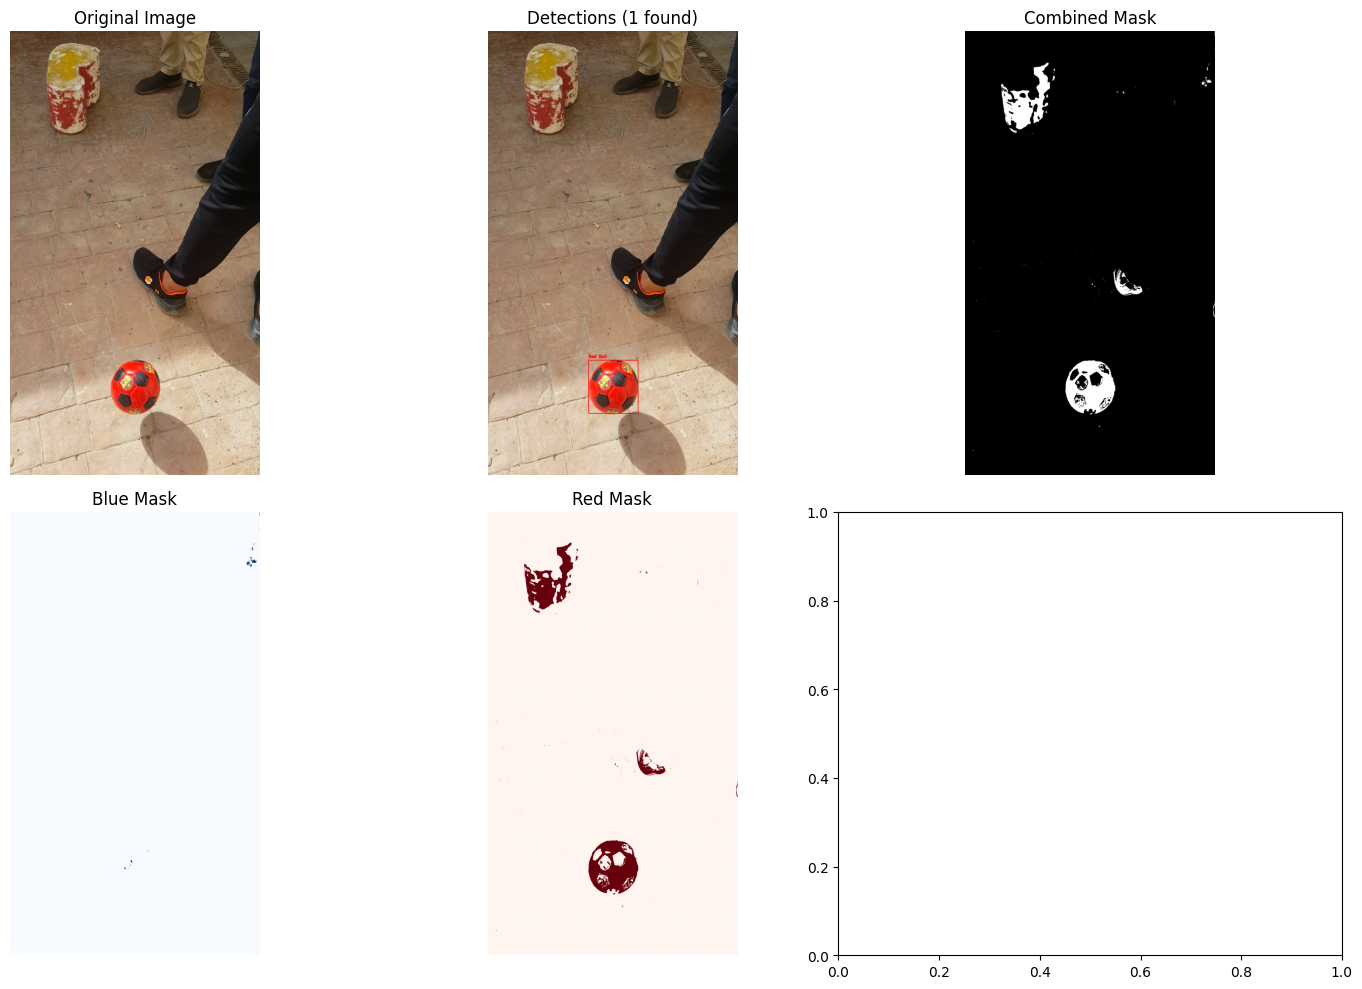

Processing: balls\ball_10.jpg
  Detected blue ball: area=75740, circularity=0.547, confidence=0.774
  Detected red ball: area=53478, circularity=0.431, confidence=0.701
  Saved 2 detections to output\ball_10.txt


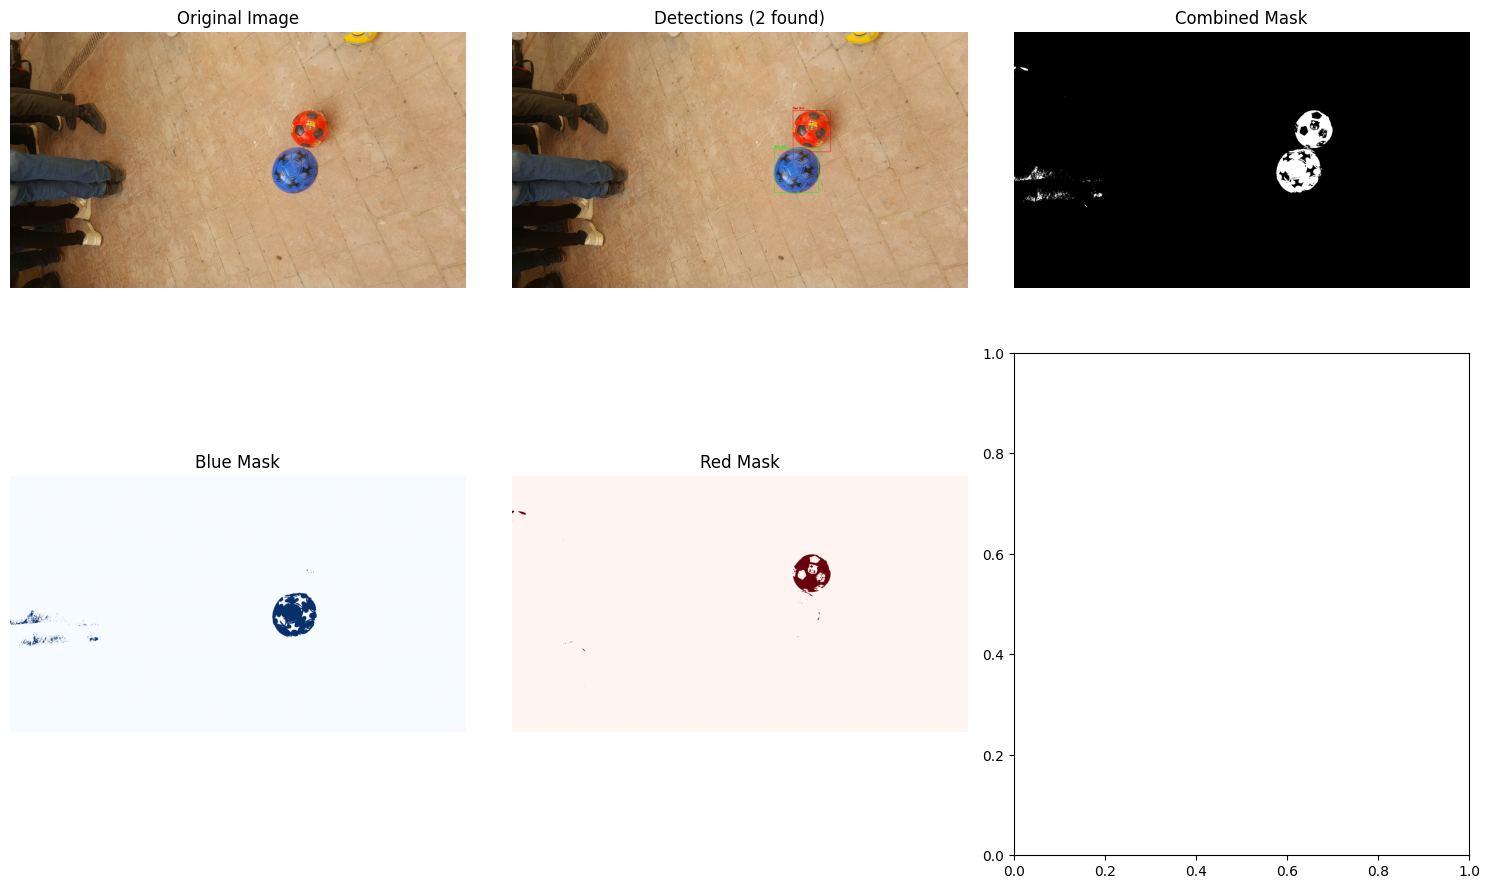

Processing: balls\ball_11.jpg
  Detected blue ball: area=8812, circularity=0.701, confidence=0.835
  Detected red ball: area=4958, circularity=0.500, confidence=0.711
  Saved 2 detections to output\ball_11.txt


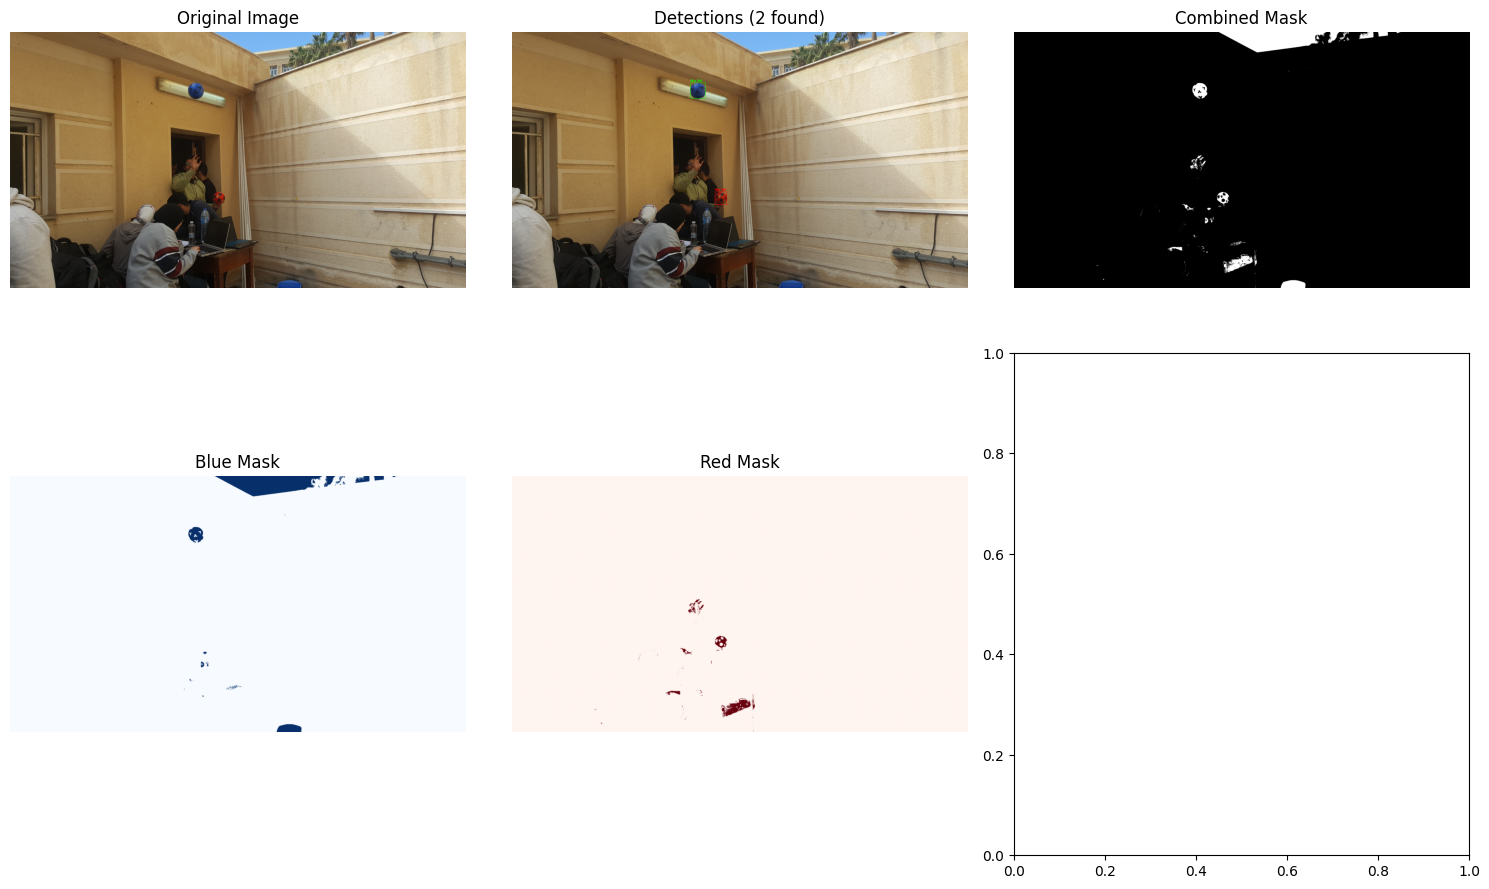

Processing: balls\ball_12.jpg
  Detected blue ball: area=569, circularity=0.914, confidence=0.946
  Saved 1 detections to output\ball_12.txt


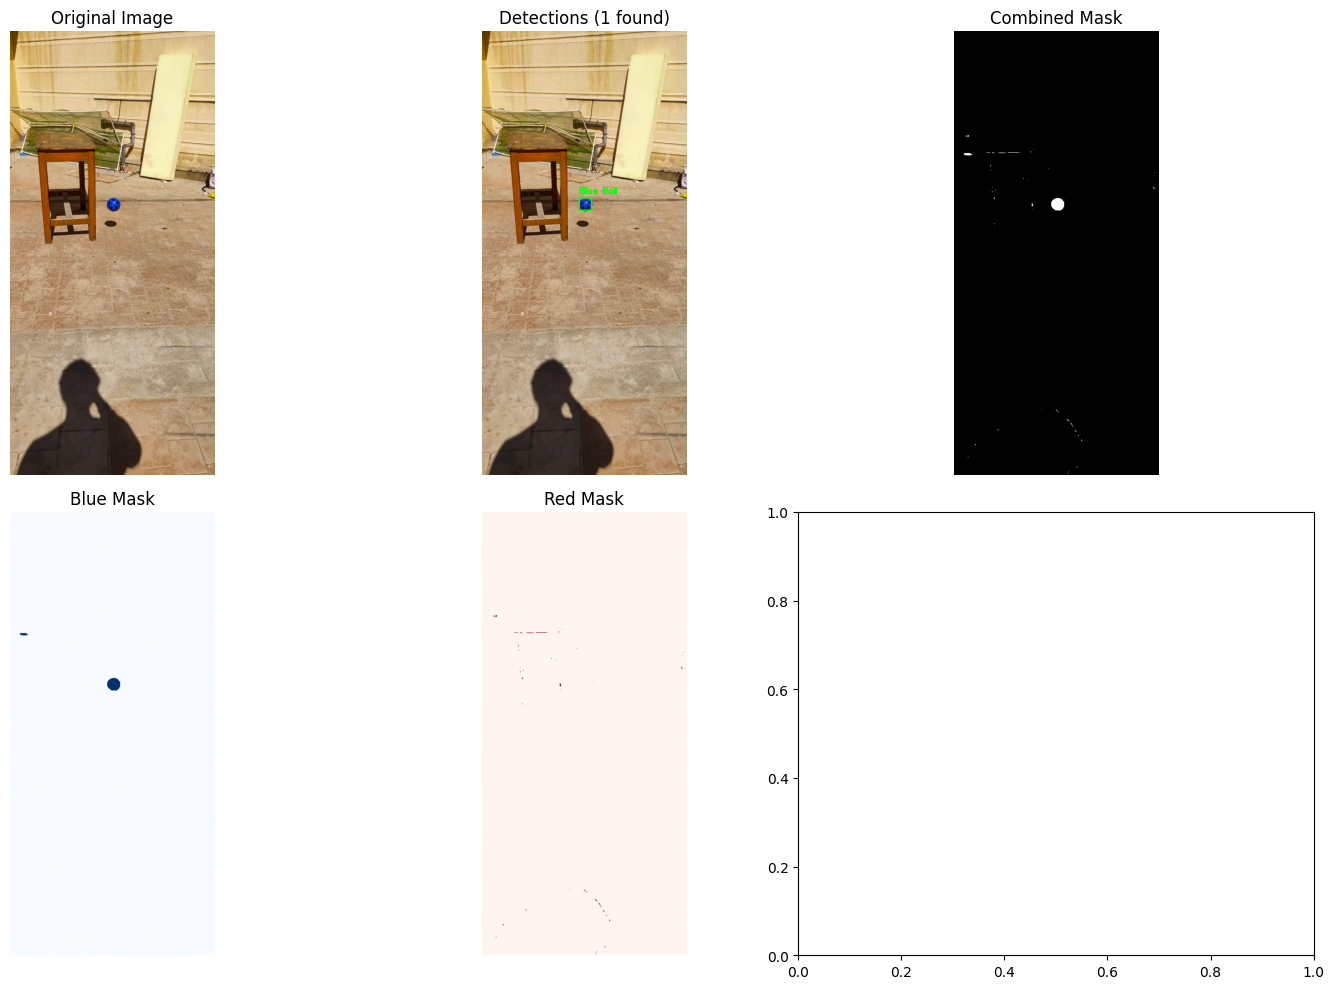

Processing: balls\ball_13.jpg
  Detected blue ball: area=41990, circularity=0.460, confidence=0.720
  Saved 1 detections to output\ball_13.txt


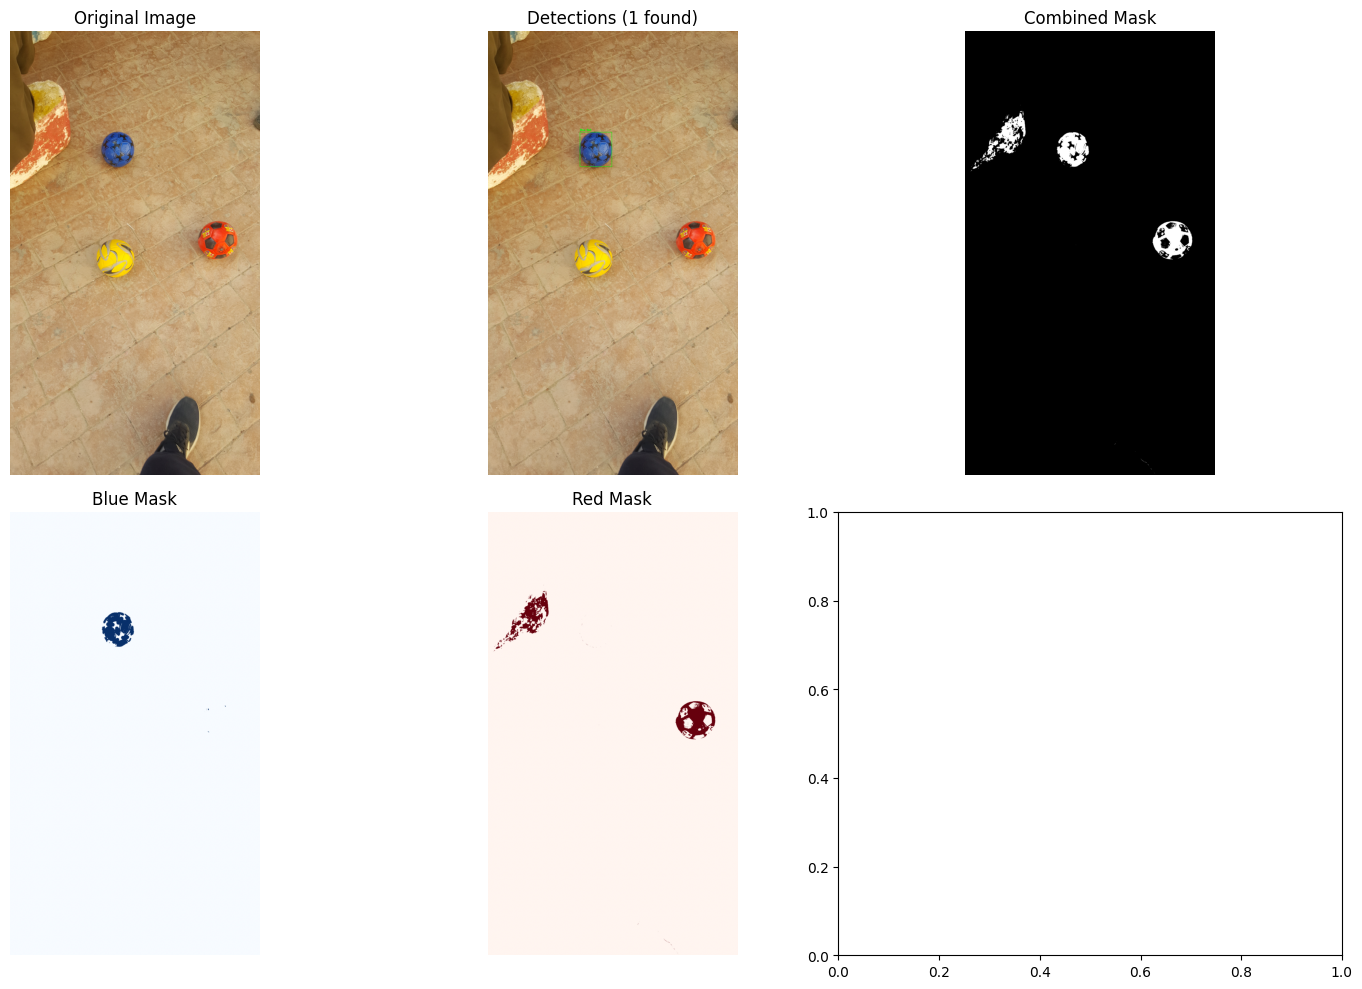

Processing: balls\ball_14.jpg
  Detected blue ball: area=3782, circularity=0.853, confidence=0.918
  Saved 1 detections to output\ball_14.txt


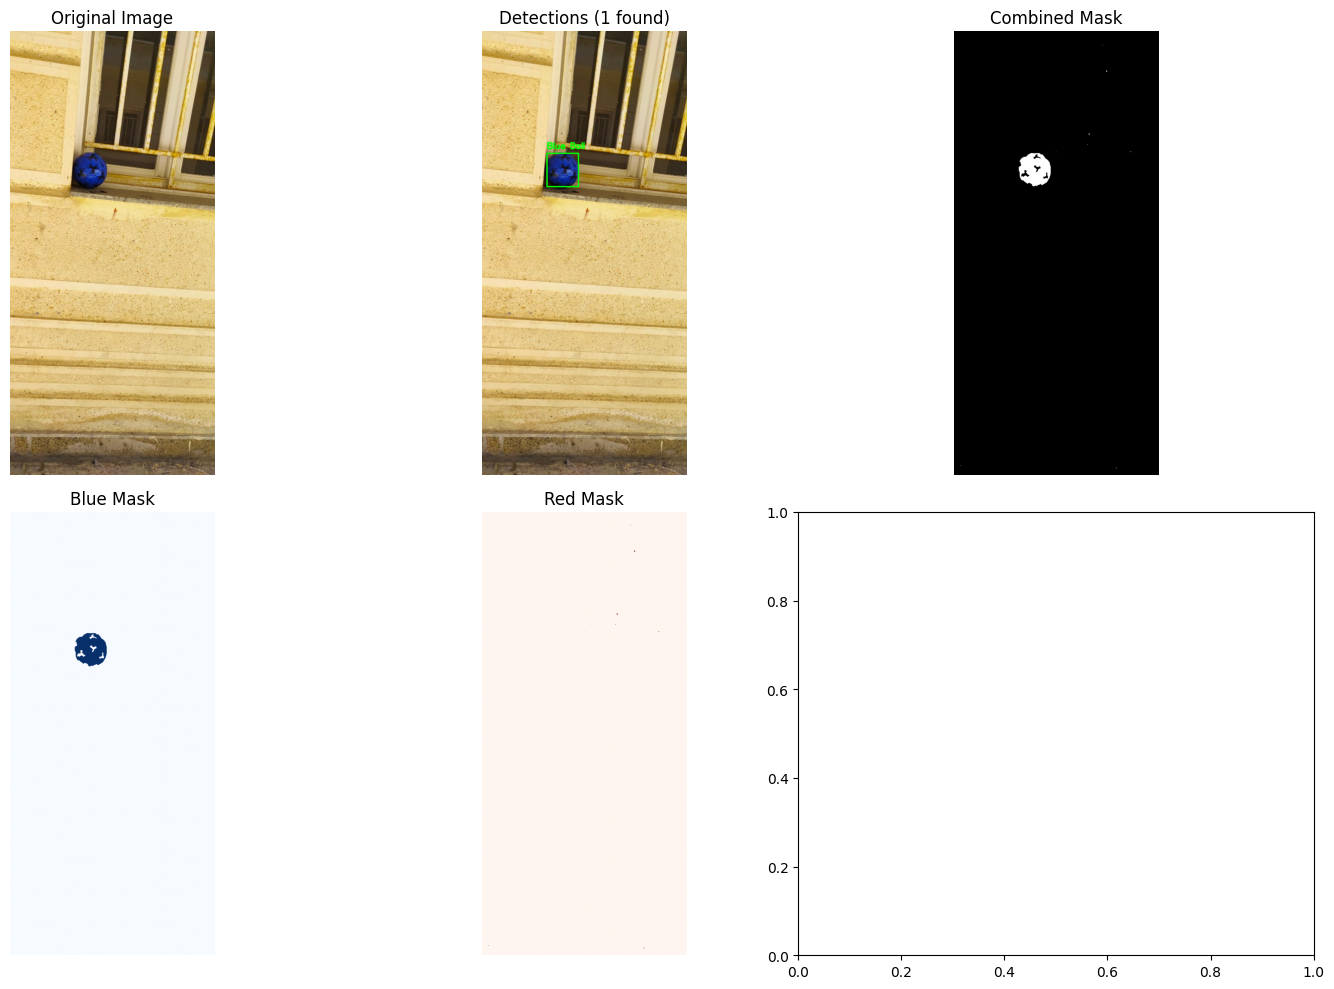

Processing: balls\ball_15.jpg
  Detected blue ball: area=1348, circularity=0.845, confidence=0.915
  Saved 1 detections to output\ball_15.txt


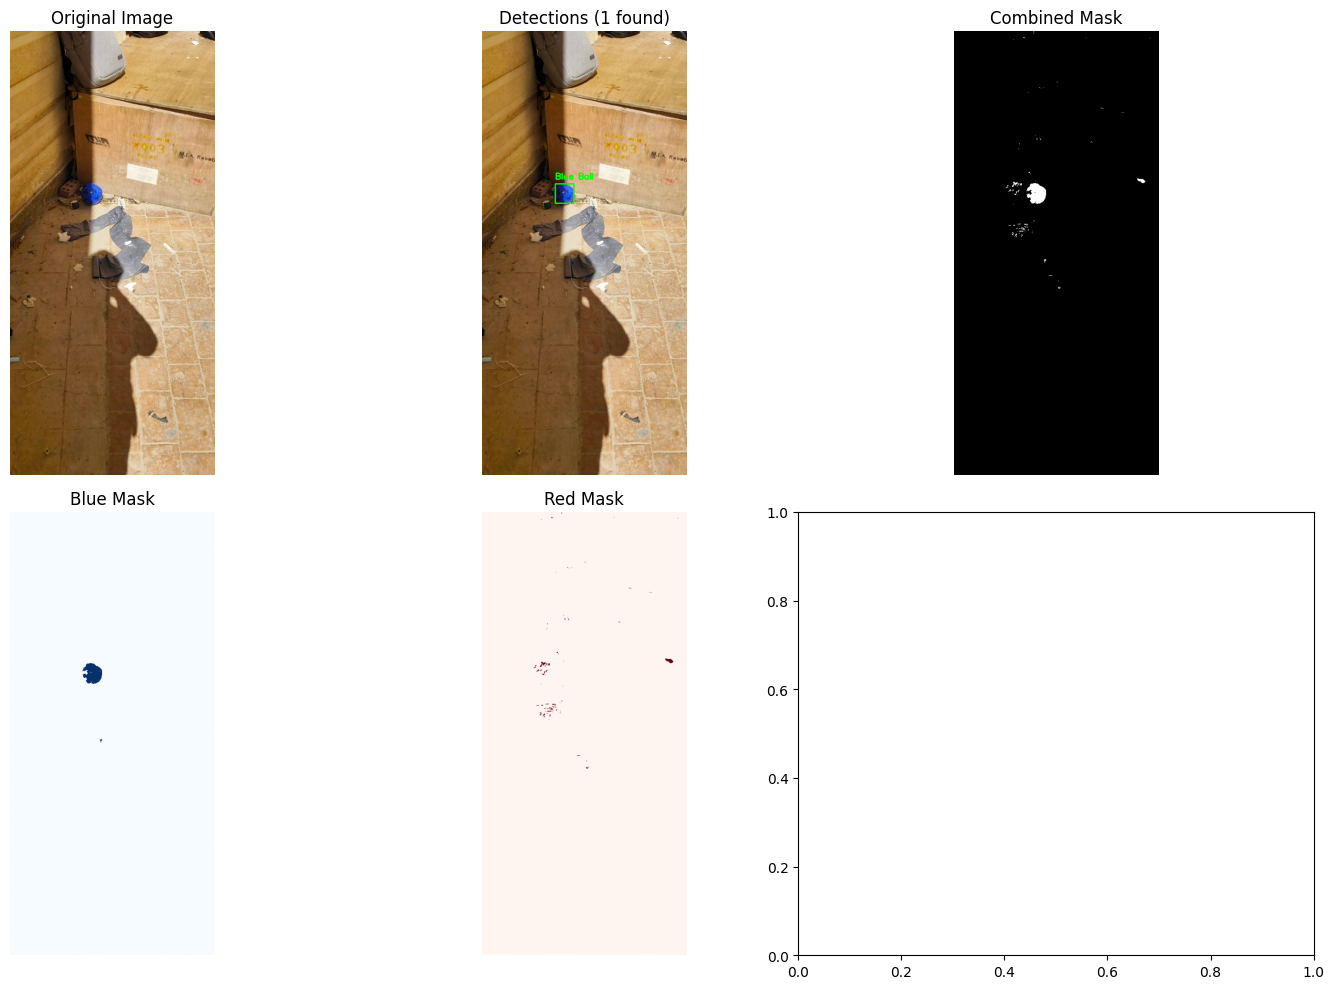

Processing: balls\ball_16.jpg
  Detected blue ball: area=446, circularity=0.531, confidence=0.561
  Detected blue ball: area=446, circularity=0.410, confidence=0.530
  Detected red ball: area=10760, circularity=0.440, confidence=0.648
  Detected red ball: area=730, circularity=0.765, confidence=0.820
  Saved 4 detections to output\ball_16.txt


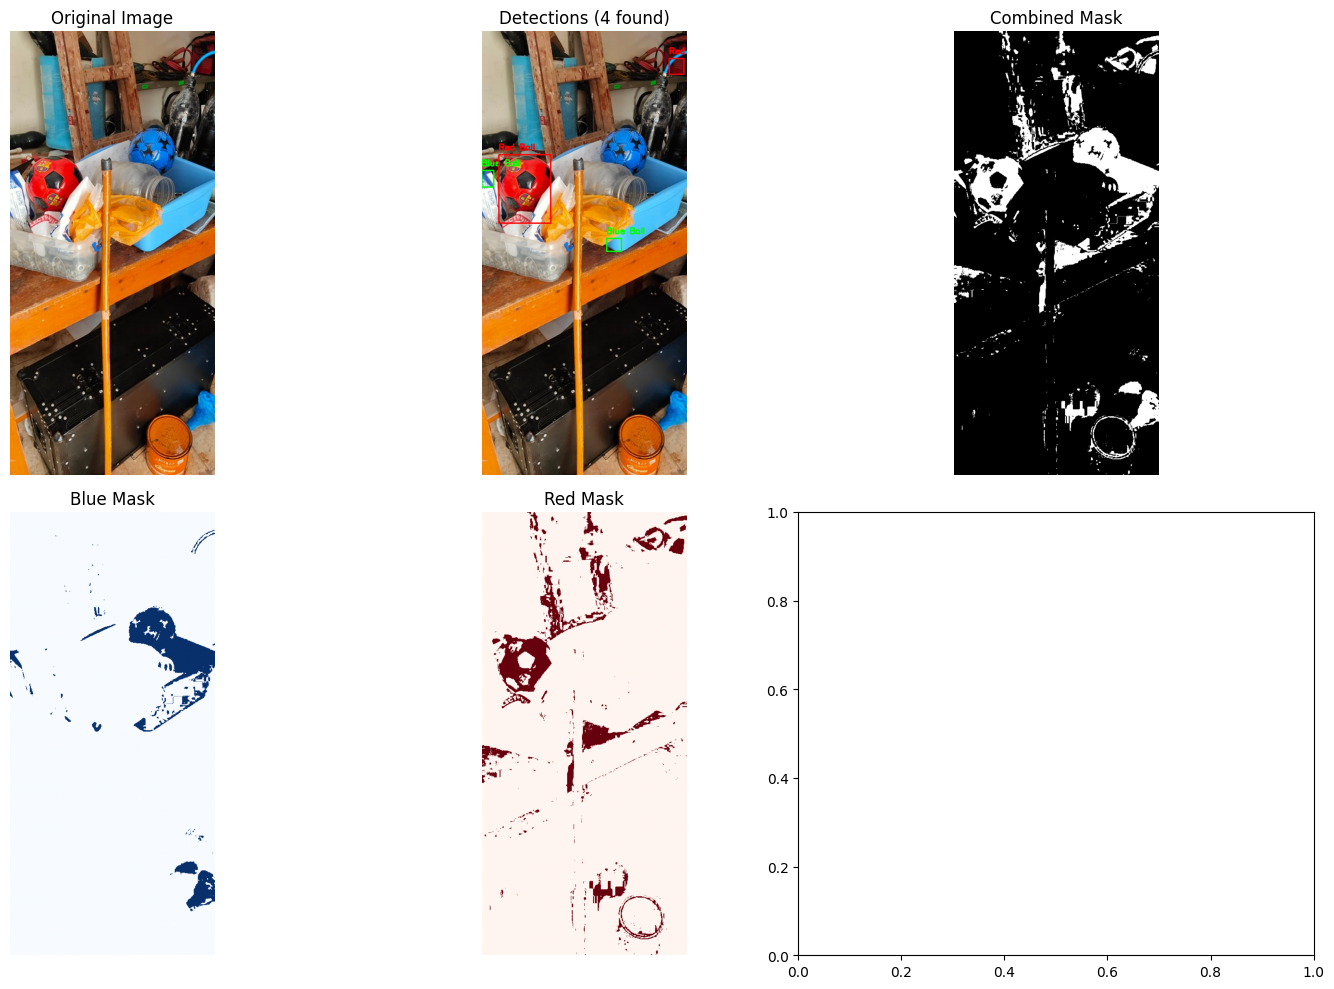

Processing: balls\ball_17.jpg
  Detected blue ball: area=5389, circularity=0.722, confidence=0.853
  Detected red ball: area=6744, circularity=0.675, confidence=0.823
  Saved 2 detections to output\ball_17.txt


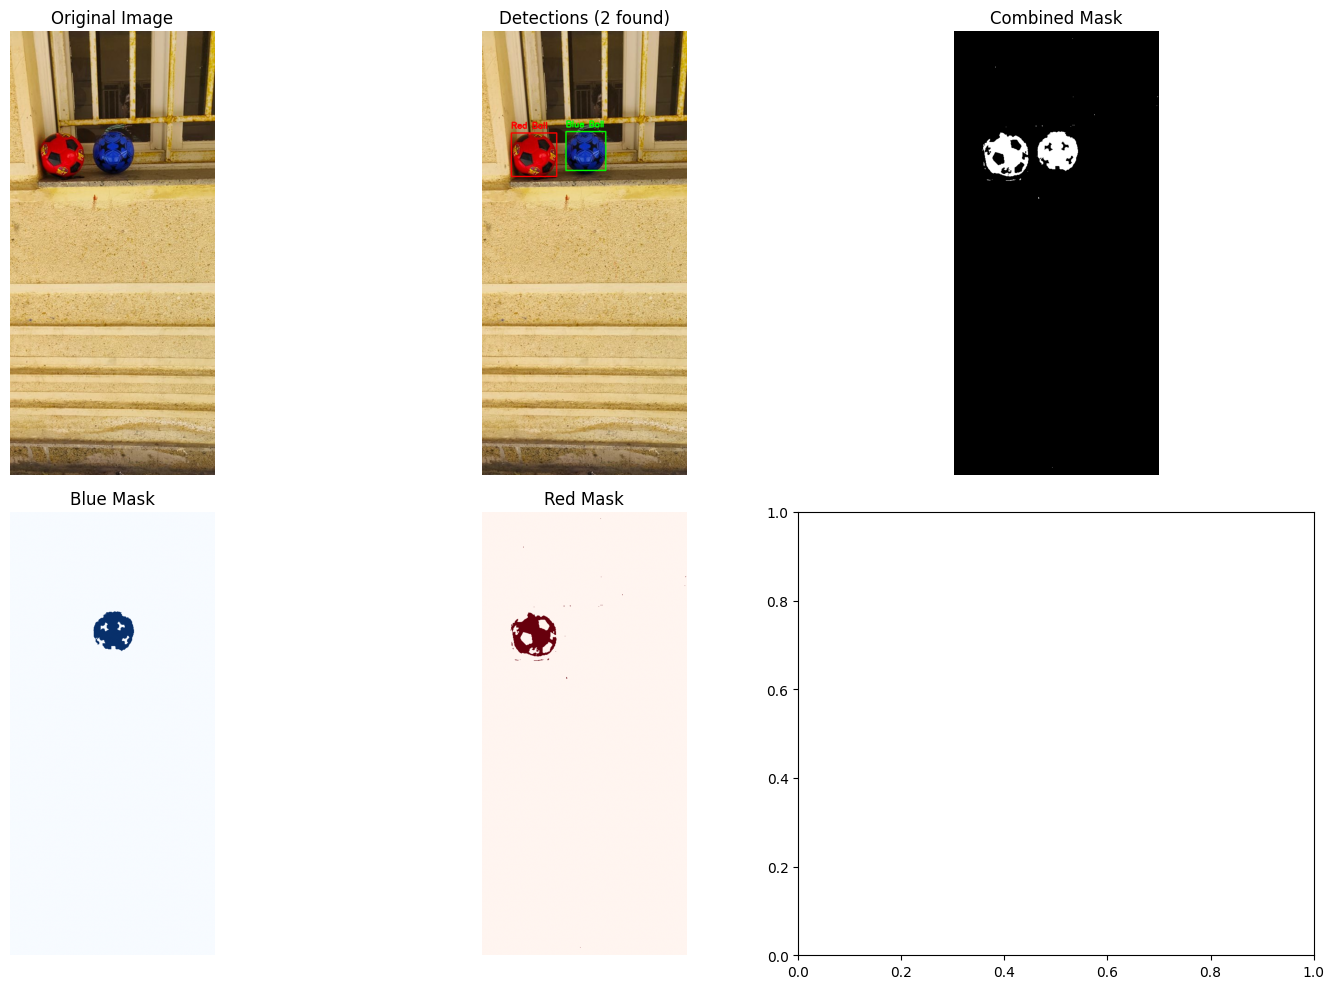

Processing: balls\ball_18.jpg
  Detected blue ball: area=1308, circularity=0.640, confidence=0.759
  Detected blue ball: area=194798, circularity=0.484, confidence=0.734
  Saved 2 detections to output\ball_18.txt


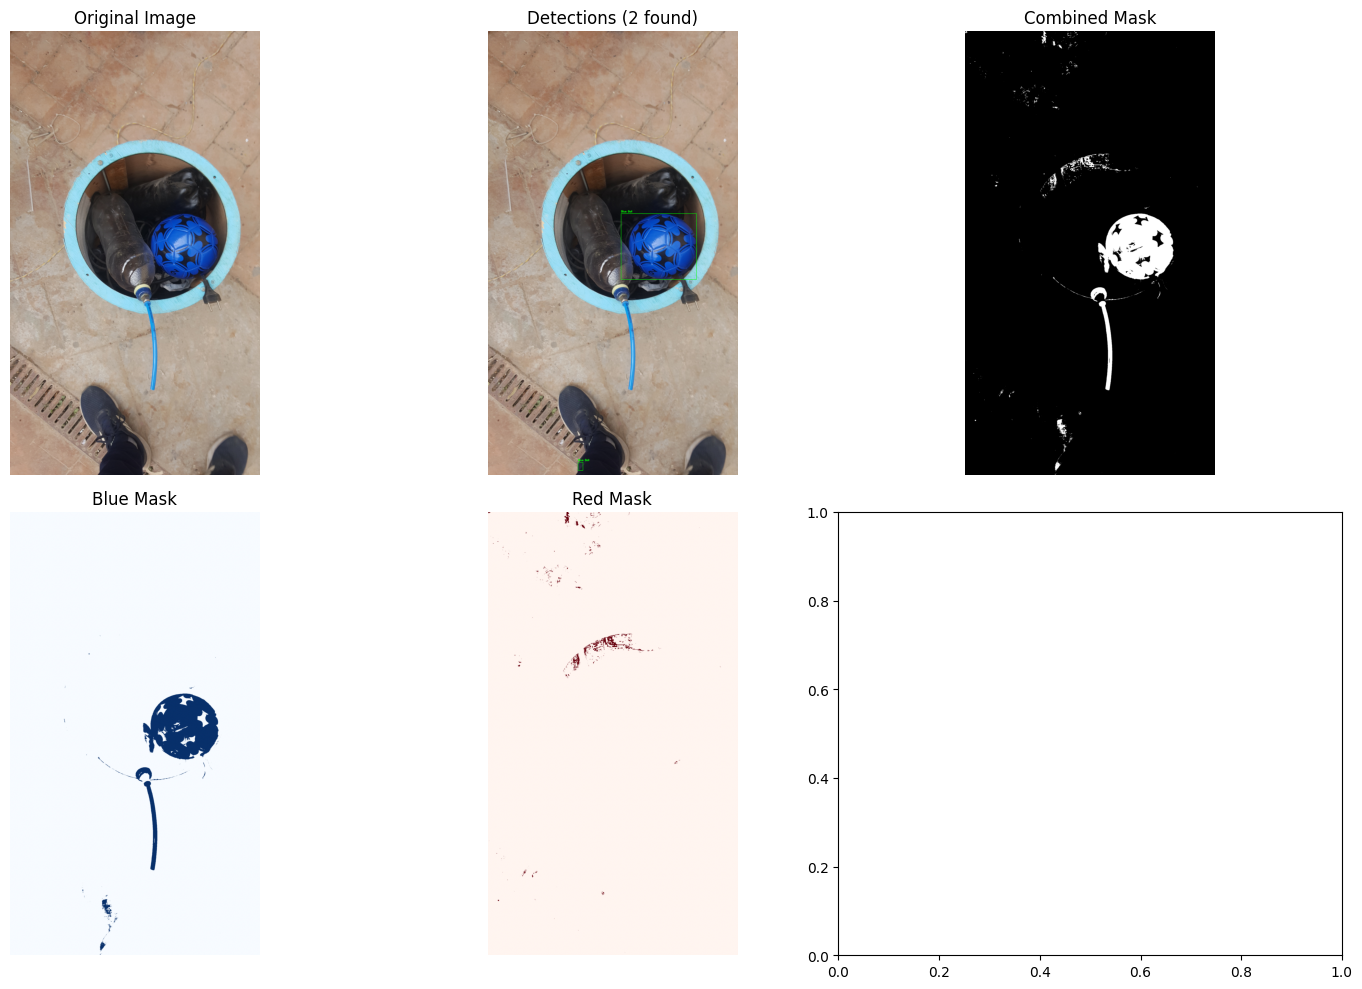

Processing: balls\ball_19.jpg
  Detected blue ball: area=2978, circularity=0.670, confidence=0.688
  Detected red ball: area=4512, circularity=0.544, confidence=0.664
  Detected red ball: area=1640, circularity=0.696, confidence=0.824
  Saved 3 detections to output\ball_19.txt


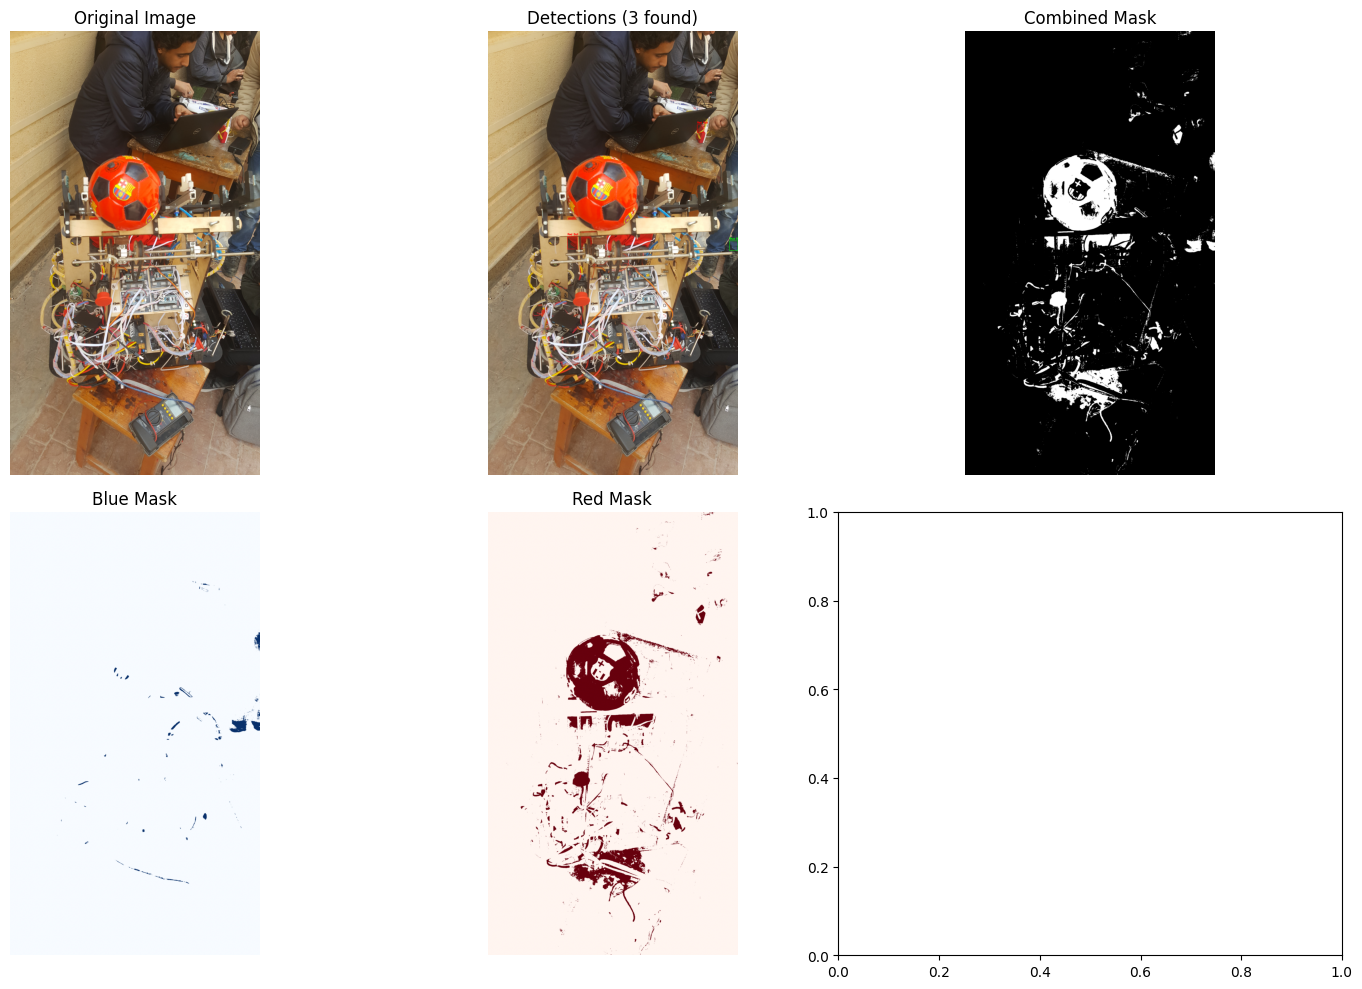

Processing: balls\ball_2.jpg
  Detected red ball: area=72238, circularity=0.847, confidence=0.921
  Saved 1 detections to output\ball_2.txt


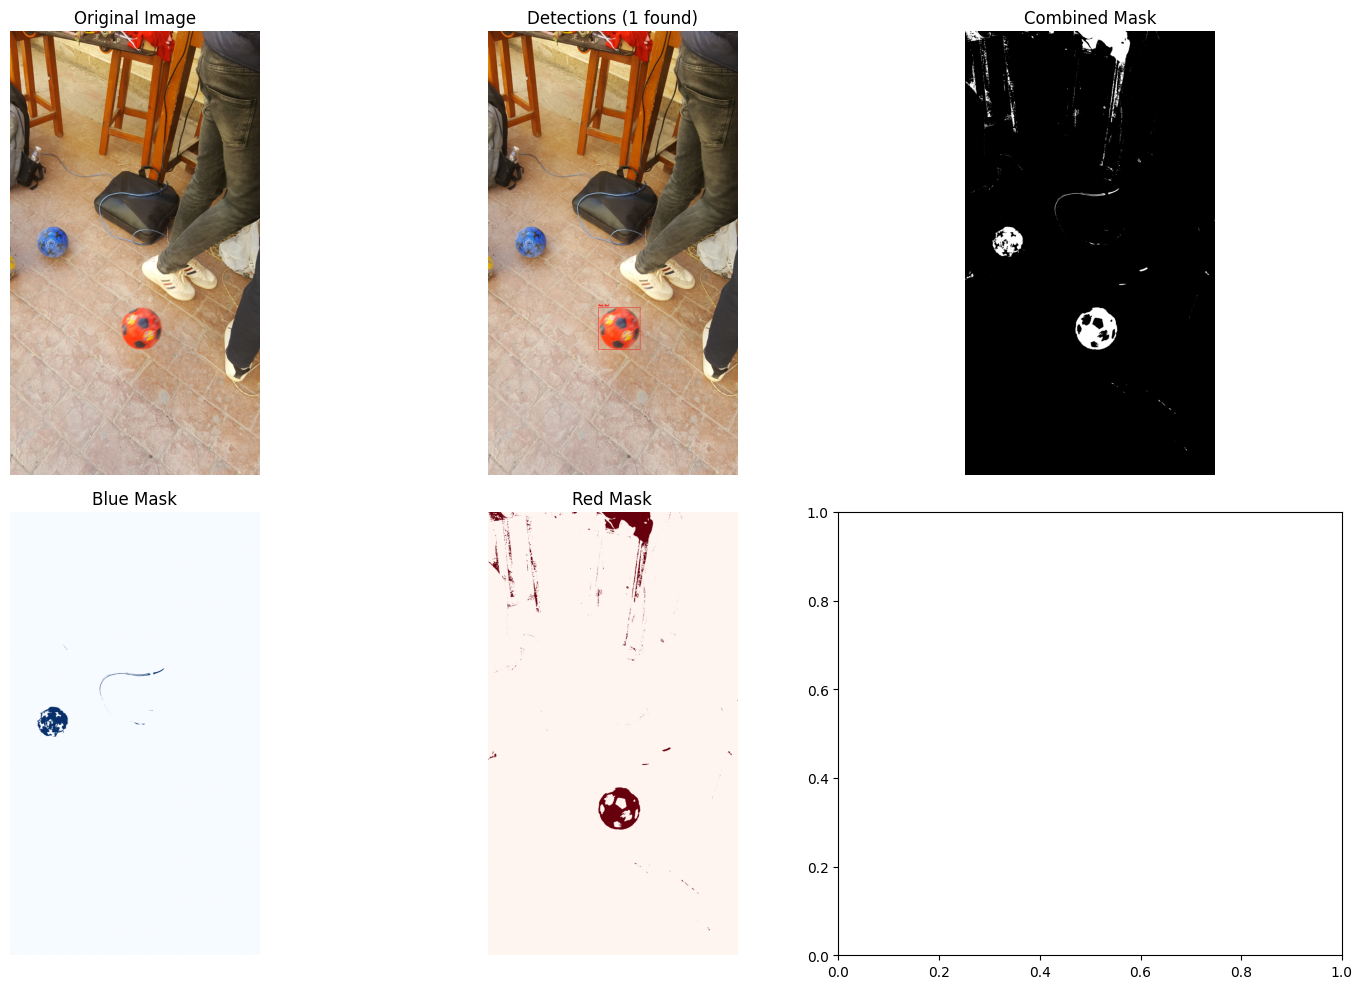

Processing: balls\ball_20.jpg
  Detected blue ball: area=1698, circularity=0.411, confidence=0.612
  Detected red ball: area=11014, circularity=0.771, confidence=0.784
  Detected red ball: area=18640, circularity=0.772, confidence=0.871
  Detected red ball: area=1448, circularity=0.503, confidence=0.692
  Detected red ball: area=5698, circularity=0.471, confidence=0.719
  Detected red ball: area=16332, circularity=0.549, confidence=0.747
  Detected red ball: area=7350, circularity=0.677, confidence=0.770
  Saved 7 detections to output\ball_20.txt


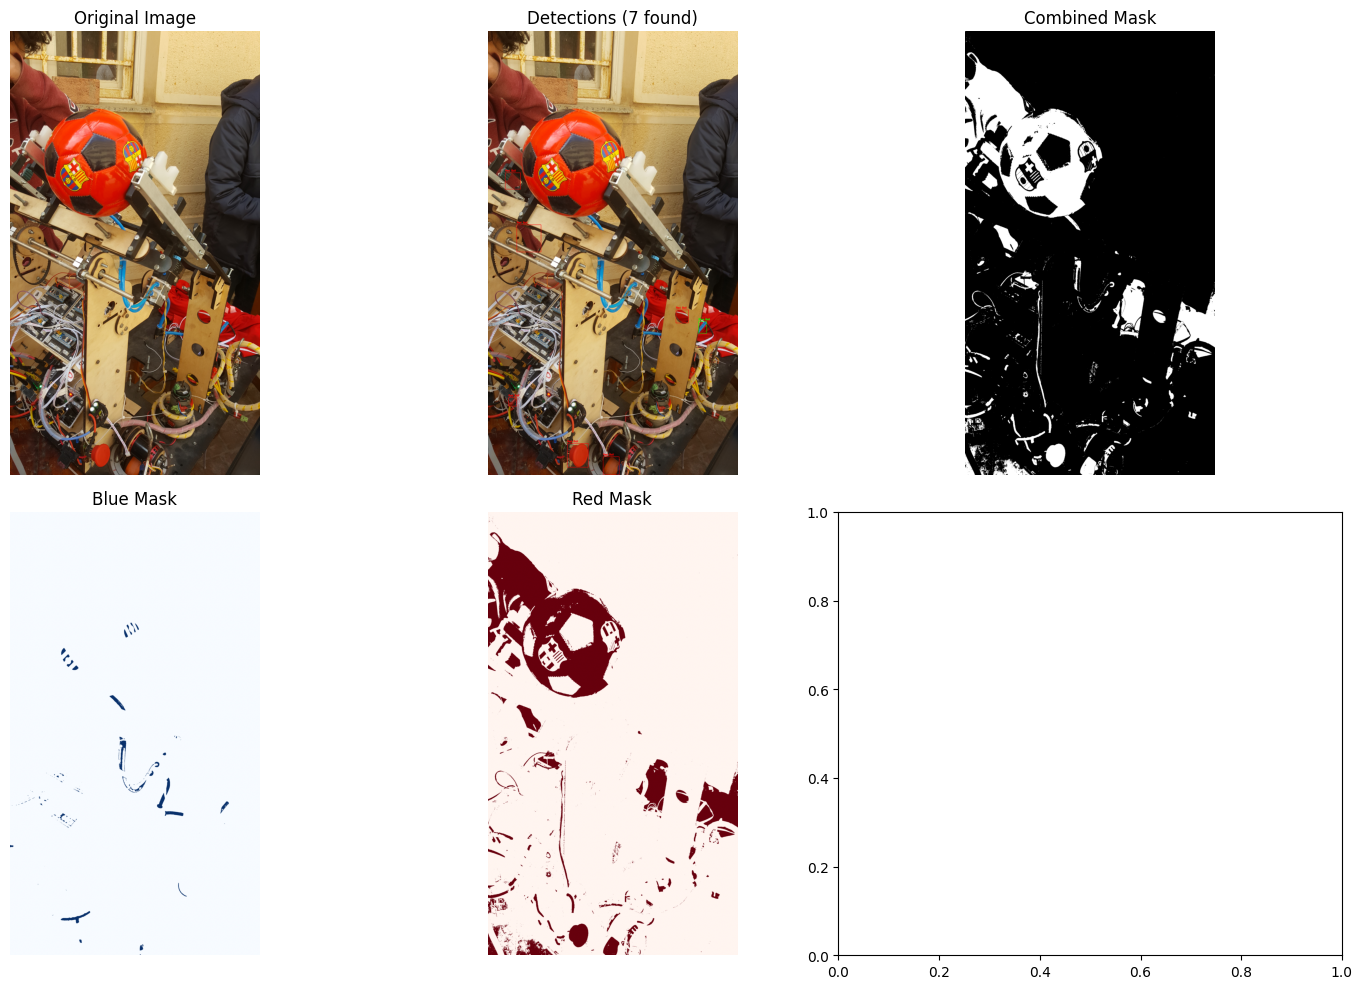

Processing: balls\ball_3.jpg
  Detected red ball: area=774, circularity=0.437, confidence=0.511
  Saved 1 detections to output\ball_3.txt


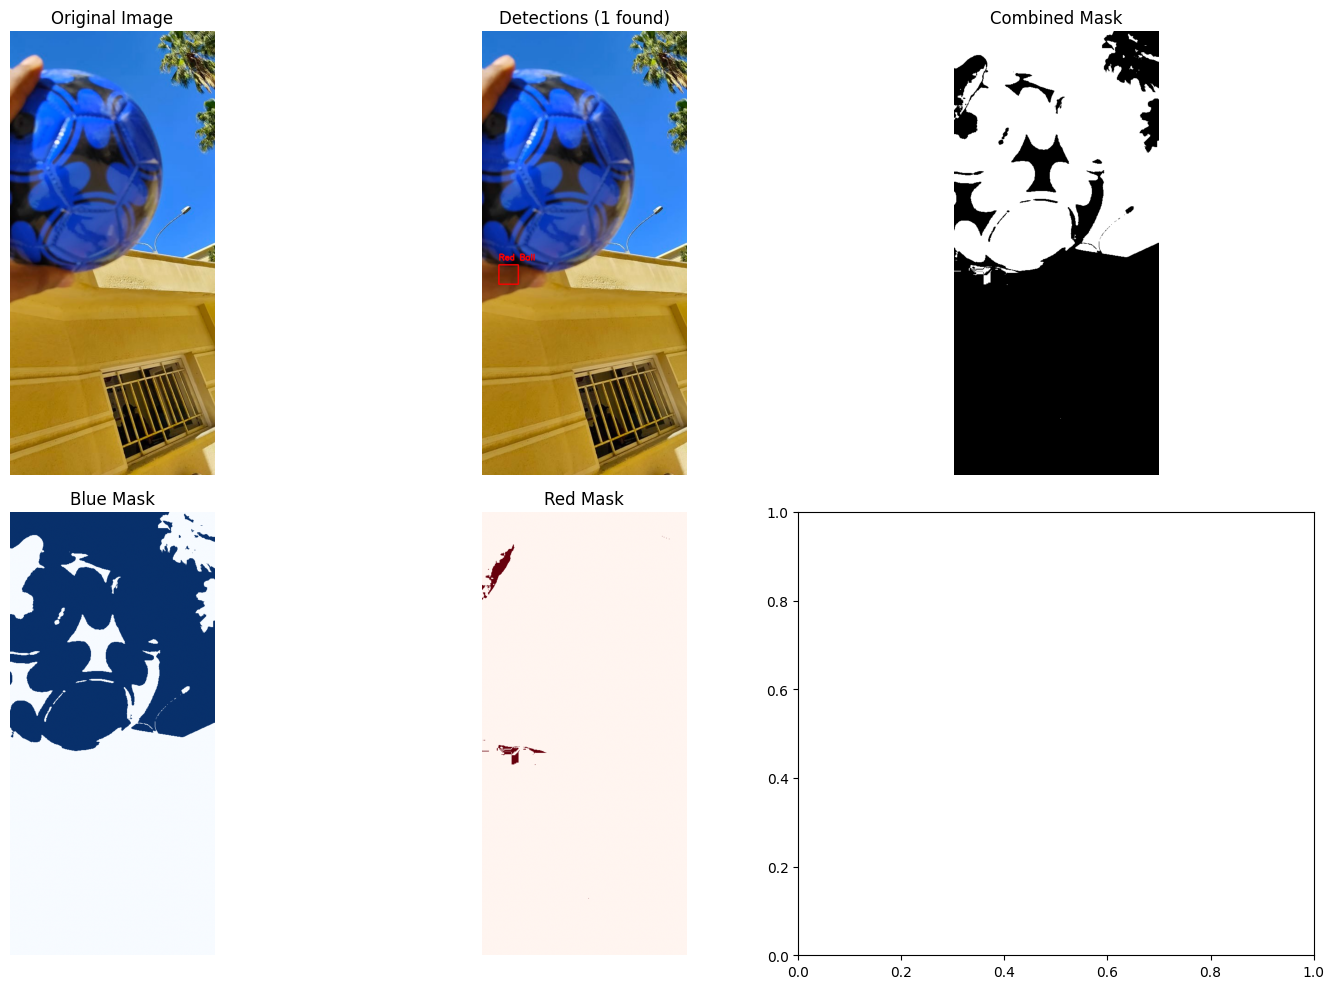

Processing: balls\ball_4.jpg
  Saved 0 detections to output\ball_4.txt


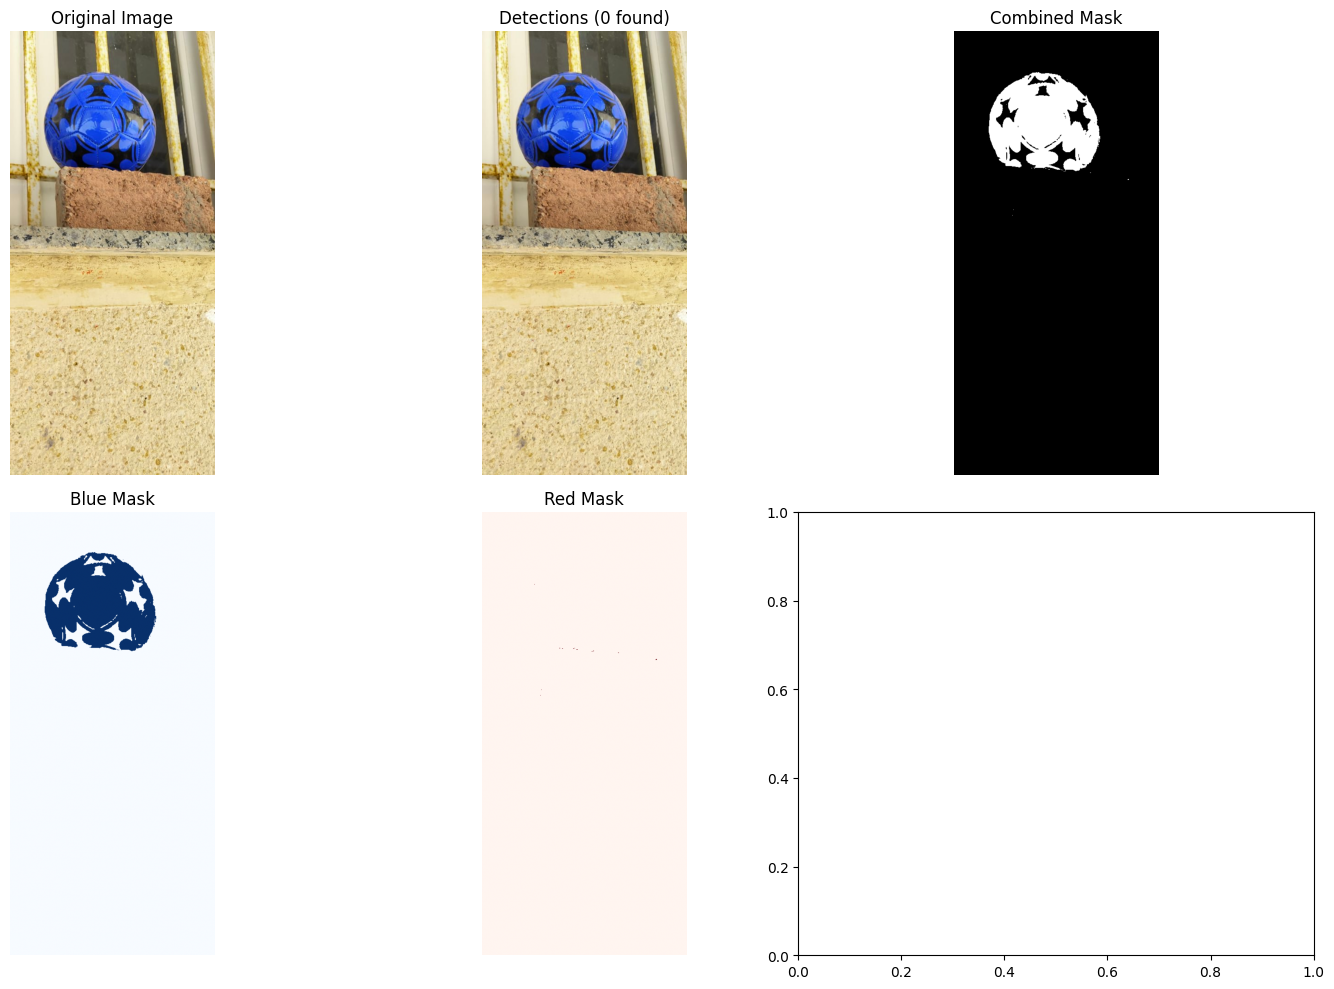

Processing: balls\ball_5.jpg
  Detected blue ball: area=2495, circularity=0.886, confidence=0.937
  Detected red ball: area=2674, circularity=0.836, confidence=0.911
  Saved 2 detections to output\ball_5.txt


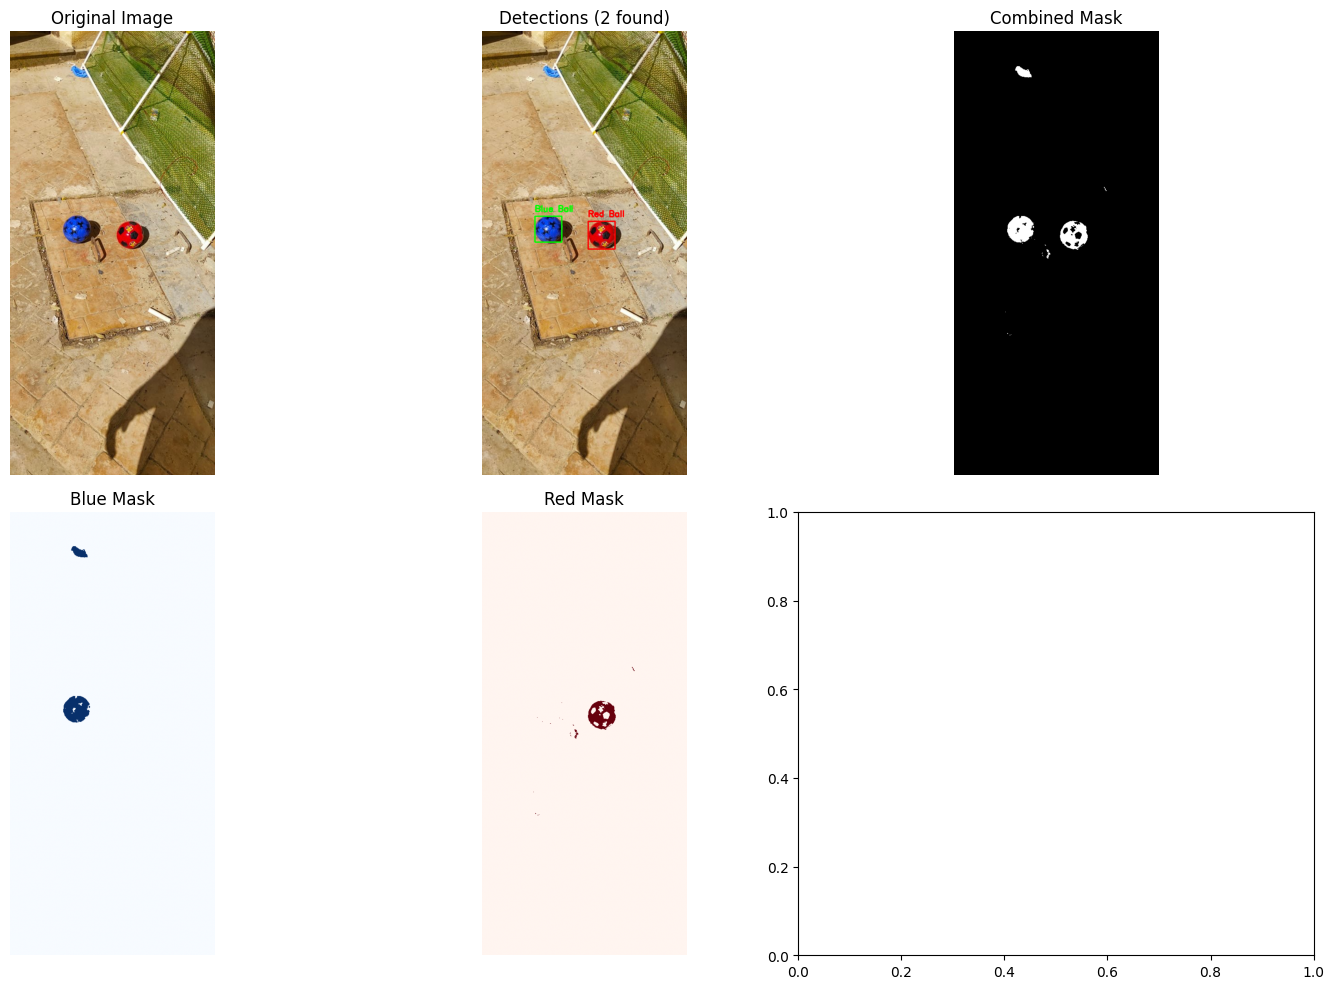

Processing: balls\ball_6.jpg
  Detected blue ball: area=3498, circularity=0.843, confidence=0.915
  Detected red ball: area=758, circularity=0.641, confidence=0.737
  Detected red ball: area=4057, circularity=0.782, confidence=0.884
  Saved 3 detections to output\ball_6.txt


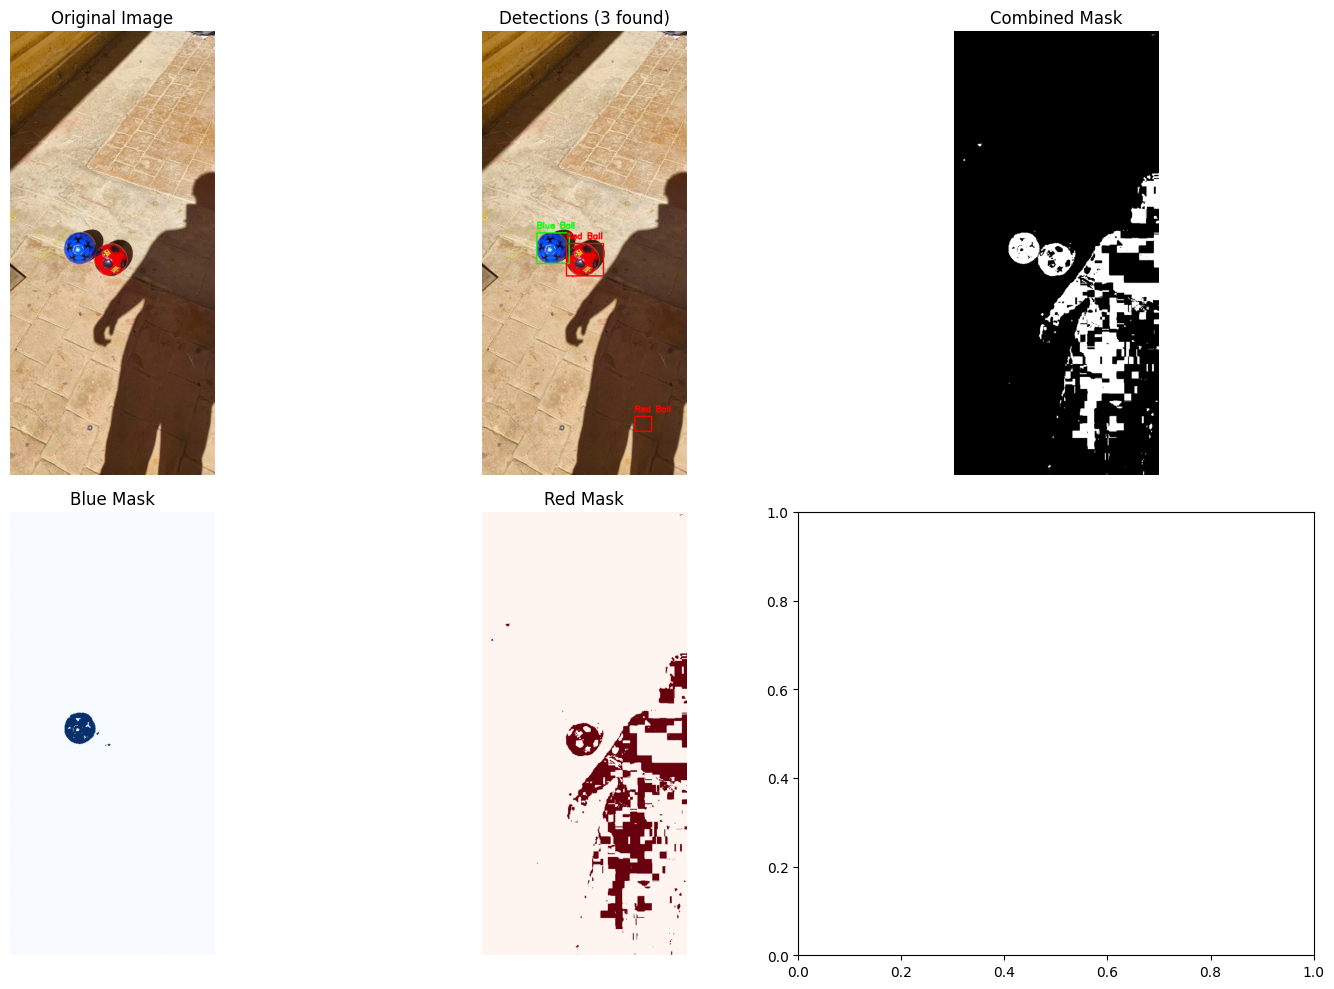

Processing: balls\ball_7.jpg
  Detected blue ball: area=313, circularity=0.577, confidence=0.751
  Detected blue ball: area=275, circularity=0.463, confidence=0.568
  Saved 2 detections to output\ball_7.txt


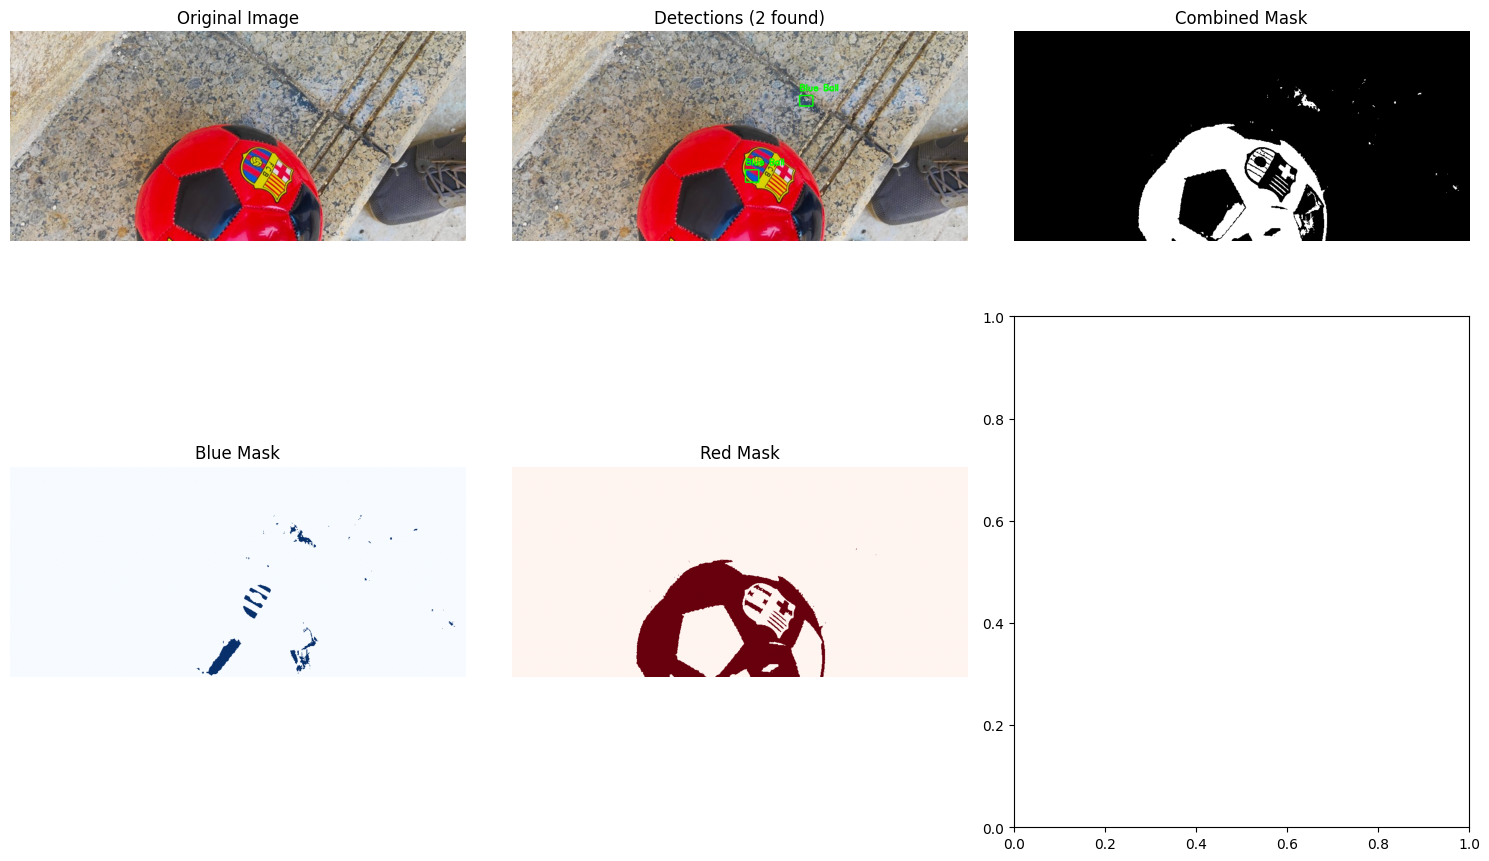

Processing: balls\ball_8.jpg
  Detected blue ball: area=19044, circularity=0.817, confidence=0.905
  Detected red ball: area=576, circularity=0.695, confidence=0.733
  Detected red ball: area=21301, circularity=0.477, confidence=0.719
  Saved 3 detections to output\ball_8.txt


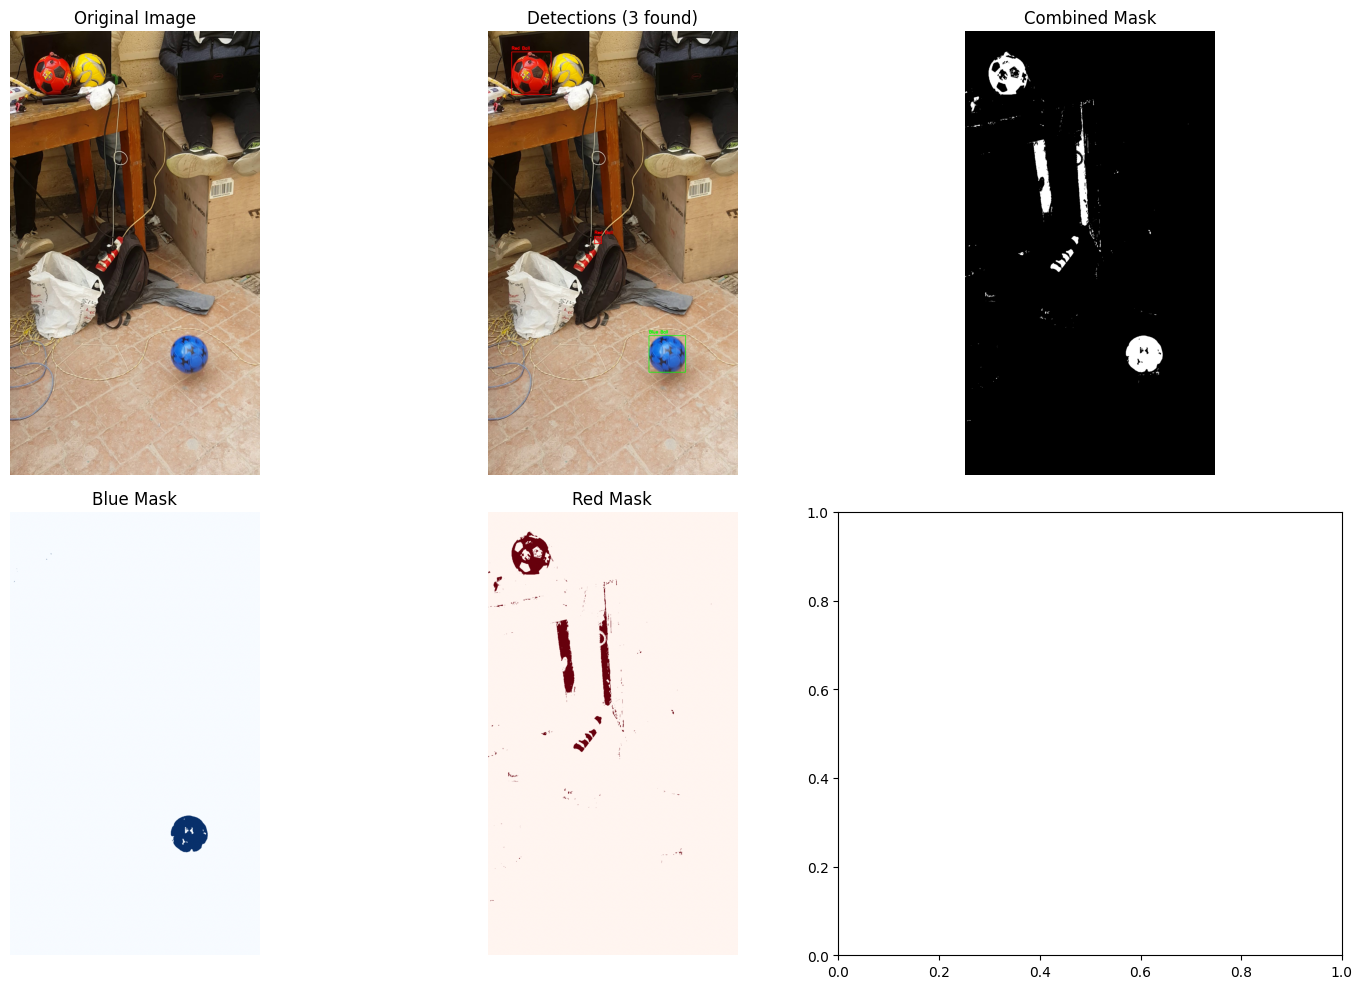

Processing: balls\ball_9.jpg
  Detected red ball: area=1118, circularity=0.459, confidence=0.566
  Saved 1 detections to output\ball_9.txt


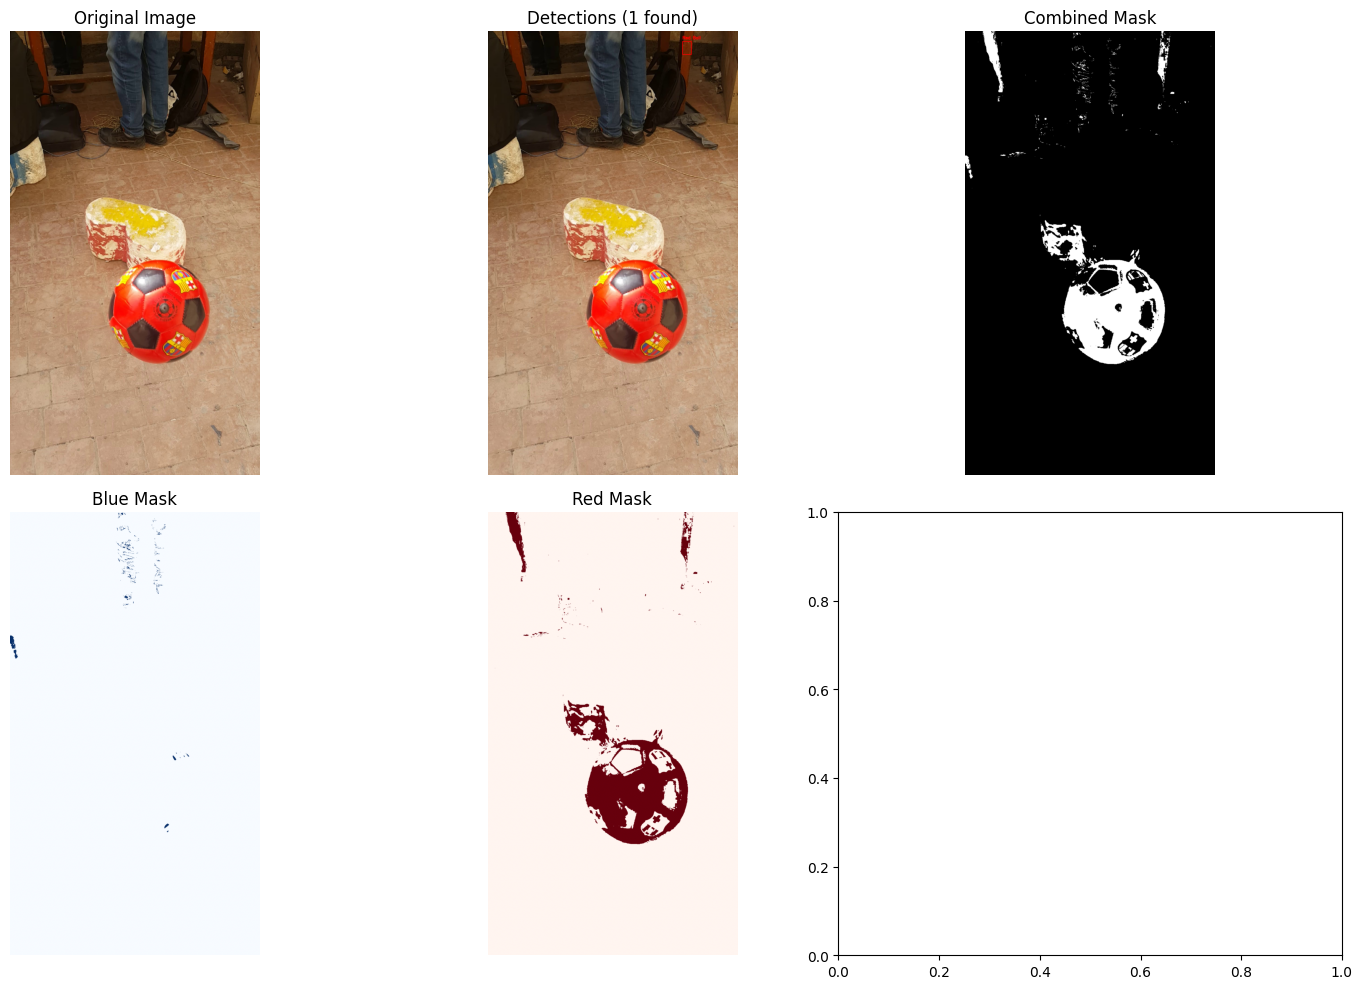

In [4]:
detect_soccer_balls("balls", "output")